In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# rt_reviews_df = pd.read_csv("/cs/labs/yweiss/adirt/NeedleInADataHaystack/data/rotten_tomatoes_critic_reviews.csv")
rt_movies_df = pd.read_csv("/cs/labs/yweiss/adirt/NeedleInADataHaystack/data/rotten_tomatoes_movies.csv")
rt_movies_df = rt_movies_df.sort_values(by="original_release_date")

FileNotFoundError: [Errno 2] No such file or directory: '/cs/labs/yweiss/adirt/NeedleInADataHaystack/data/rotten_tomatoes_movies.csv'

In [ ]:
# reviews_df = rt_reviews_df.merge(rt_movies_df, on="rotten_tomatoes_link")
# reviews_df = reviews_df.sort_values(by="original_release_date")
# reviews_df.original_release_date

218168     1914-06-01
218178     1914-06-01
218179     1914-06-01
218180     1914-06-01
218181     1914-06-01
              ...    
1128384           NaN
1128385           NaN
1128386           NaN
1128387           NaN
1128388           NaN
Name: original_release_date, Length: 1129887, dtype: object

In [56]:
selected_movies = rt_movies_df.query("movie_title.str.contains('The Lord of the Rings') and original_release_date > '2000-01-01'")
selected_movies

,rotten_tomatoes_link,movie_title,movie_info,critics_consensus,content_rating,genres,directors,authors,actors,original_release_date,...,production_company,tomatometer_status,tomatometer_rating,tomatometer_count,audience_status,audience_rating,audience_count,tomatometer_top_critics_count,tomatometer_fresh_critics_count,tomatometer_rotten_critics_count
15409,m/the_lord_of_the_rings_the_fellowship_of_the_...,The Lord of the Rings: The Fellowship of the Ring,The future of civilization rests in the fate o...,"Full of eye-popping special effects, and featu...",PG-13,"Action & Adventure, Classics, Drama, Science F...",Peter Jackson,"Fran Walsh, Peter Jackson, Philippa Boyens","Elijah Wood, Ian McKellen, Viggo Mortensen, Li...",2001-12-19,...,New Line Cinema,Certified-Fresh,91.0,233.0,Upright,95.0,1355751.0,48,213,20
15411,m/the_lord_of_the_rings_the_two_towers,The Lord of the Rings: The Two Towers,The sequel to the Golden Globe-nominated and A...,The Two Towers balances spectacular action wit...,PG-13,"Action & Adventure, Classics, Drama, Science F...",Peter Jackson,"Philippa Boyens, Stephen Sinclair, Fran Walsh","Elijah Wood, Ian McKellen, Viggo Mortensen, Se...",2002-12-12,...,New Line Cinema,Certified-Fresh,95.0,255.0,Upright,95.0,1341428.0,52,243,12
15410,m/the_lord_of_the_rings_the_return_of_the_king,The Lord of the Rings: The Return of the King,The culmination of nearly 10 years' work and c...,Visually breathtaking and emotionally powerful...,PG-13,"Action & Adventure, Classics, Science Fiction ...",Peter Jackson,"Fran Walsh, Philippa Boyens, Peter Jackson","Elijah Wood, Sean Astin, Ian McKellen, Andy Se...",2003-12-17,...,New Line Cinema,Certified-Fresh,93.0,275.0,Upright,86.0,34679773.0,53,257,18


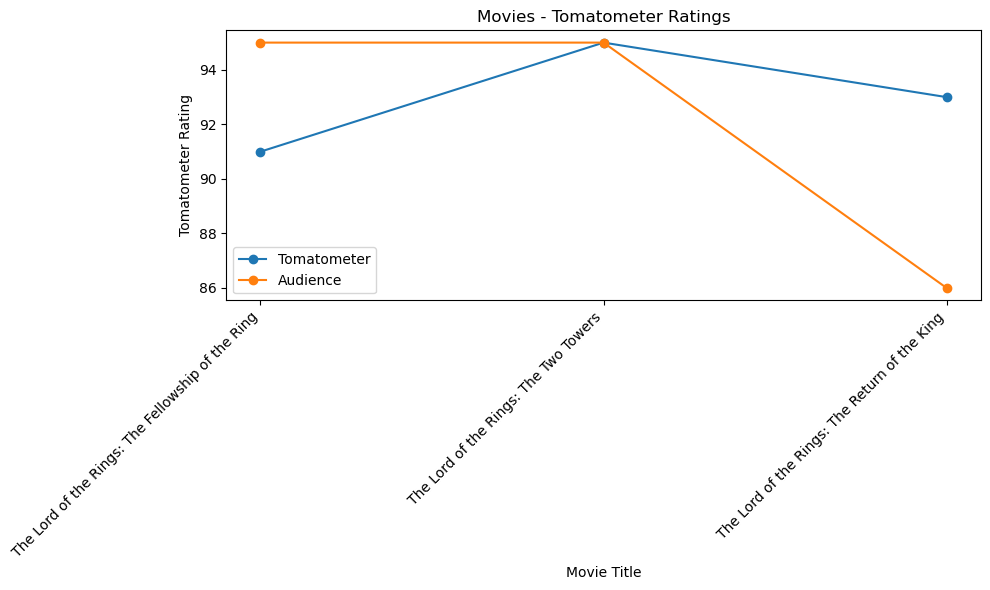

In [57]:
plt.figure(figsize=(10, 6))
plt.plot(selected_movies.movie_title, selected_movies.tomatometer_rating, marker='o', label='Tomatometer')
plt.plot(selected_movies.movie_title, selected_movies.audience_rating, marker='o', label='Audience')
plt.legend()
plt.xticks(rotation=45, ha='right')
plt.xlabel('Movie Title')
plt.ylabel('Tomatometer Rating')
plt.title('Movies - Tomatometer Ratings')
plt.tight_layout()
plt.show()

In [4]:
rt_franchise_and_series_df = pd.read_csv("./data/rotten_tomatoes_series_and_frachise.csv")

In [5]:
rt_franchise_and_series_df

,rotten_tomatoes_link,wd_film_qid,wd_film_label,series_qid,series_label,franchise_qid,franchise_label
0,m/cabiria,Q1024861,Cabiria,NaN,NaN,NaN,NaN
1,m/fool_there_was,Q933724,A Fool There Was,NaN,NaN,NaN,NaN
2,m/birth_of_a_nation,Q220394,The Birth of a Nation,NaN,NaN,NaN,NaN
3,m/1010644-intolerance,Q192206,Intolerance,NaN,NaN,NaN,NaN
4,m/1003120-broken_blossoms,Q905932,Broken Blossoms,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
17707,m/your_son,Q58159412,Tu hijo,NaN,NaN,NaN,NaN
17708,m/z_2019,Q106935349,Z,NaN,NaN,NaN,NaN
17709,m/zambezia,Q564661,Zambezia,NaN,NaN,NaN,NaN
17710,m/ziegfeld_follies,Q2186004,Ziegfeld Follies,NaN,NaN,NaN,NaN
